----------------------

## Оценка поведения пользователей и анализ поездок сервиса аренды


### Введение

В данном проекте мы проводим анализ данных сервиса аренды самокатов, чтобы понять поведение пользователей и выявить ключевые факторы, влияющие на использование сервиса


Основная цель — выявить различия в поведении пользователей с подпиской и без неё, оценить типичные расстояния поездок, а также проверить влияние технических изменений на работу приложения


Задачи:

- Провести исследовательский анализ данных

- Выявить выбросы и аномалии в данных

- Проверить гипотезы, касающиеся поведения пользователей

- Подготовить отчёт с основными выводами


# Шаг 1. Загрузка данных


In [1]:
import pandas as pd
from scipy import stats as st
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns


In [2]:
users_df =  pd.read_csv('/datasets/users_go.csv')
rides_df = pd.read_csv('/datasets/rides_go.csv')
subs_df  =  pd.read_csv('/datasets/subscriptions_go.csv')

In [3]:
users_df.info()
users_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
rides_df.info()
rides_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [5]:
subs_df.info()
subs_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Данные выглядит корректнo, без пропусков

## Шаг 2. Предобработка данных



### Приведем столбцы к нужному виду

In [6]:
rides_df['date'] = pd.to_datetime(rides_df['date'])
rides_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


### 2.2

In [7]:
rides_df['month'] = rides_df['date'].dt.month
rides_df.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


### Проверим данные на пропуски

In [8]:
missing_values_users = users_df.isnull().sum()
missing_values_rides = rides_df.isnull().sum()
missing_values_subscriptions = subs_df.isnull().sum()

print(missing_values_users)
print()
print(missing_values_rides)
print()
print(missing_values_subscriptions)

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64


**Пропущенных значений не обнаружено**

### Проверяем данные на дубликаты

In [9]:
duplicates_users = users_df.duplicated().sum()
duplicates_rides = rides_df.duplicated().sum()
duplicates_subscriptions = subs_df.duplicated().sum()

print(duplicates_users)
print(duplicates_rides)
print(duplicates_subscriptions)

31
0
0


In [10]:
users_df = users_df.drop_duplicates()


In [11]:
duplicates_users_updated = users_df.duplicated().sum()

print(duplicates_users_updated)


0


In [12]:
users_df.info()
print()
rides_df.info()
print()
subs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 71.9+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB

<class 'pan

**Было удалено 31 дубликатов из датасета users_df**

В предобработке данных 
 - добавили новый столбец, который показывает месяц в котором была совершена поездка
 - удалили все дубликаты
 - проверили на пропущенные значения
 

## Шаг 3. Исследовательский анализ данных

### Частота встречаемости городов

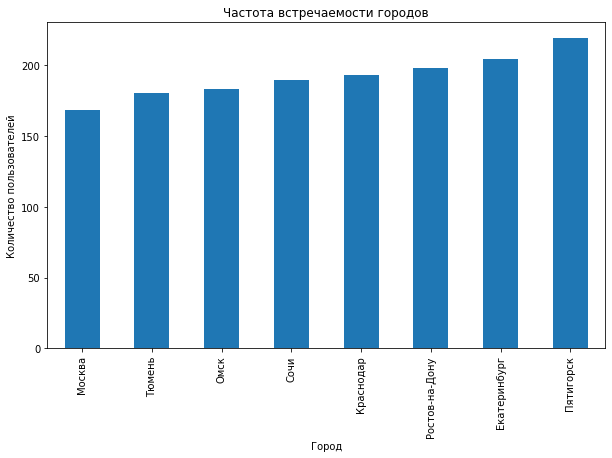

In [13]:
city_frequency = users_df['city'].value_counts(ascending=True)

plt.figure(figsize=(10, 6))
city_frequency.plot(kind='bar')
plt.title('Частота встречаемости городов')
plt.xlabel('Город')
plt.ylabel('Количество пользователей')
plt.show()


Из графика видно, что большое количество из Пятигорска и Екатеринбурга, Москва располагается на 8 месте, а Санкт-Петербург даже не в топе

### Соотношение пользователей с подпиской и без подписки

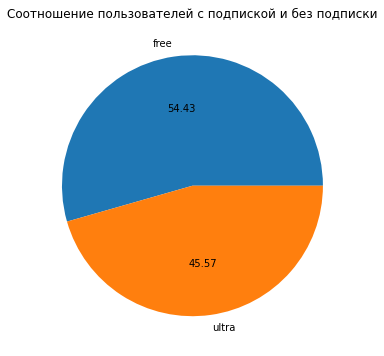

In [14]:
subscription_proportion = users_df['subscription_type'].value_counts()

plt.figure(figsize=(6, 6))
subscription_proportion.plot(kind='pie', autopct='%.2f')
plt.title('Соотношение пользователей с подпиской и без подписки')
plt.ylabel('')
plt.show()



больше половины пользователей используют подписку free, но также стоит отметить,что подпиской ultra пользуется более 40% пользователей

### Распределение возраста пользователей

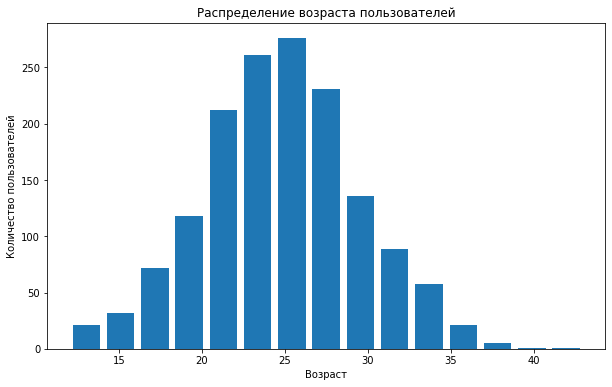

In [15]:
age_distribution = users_df['age']

plt.figure(figsize=(10, 6))
age_distribution.plot(kind='hist', bins=15, rwidth=0.8)
plt.title('Распределение возраста пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.show()

Основная часть пользователей находится в диапозоне от 20 до 35 лет. Это соответствует тому,что молодые люди чаще пользуются кикшерингом нежели старое поколение


### Распределение расстояния за поездку

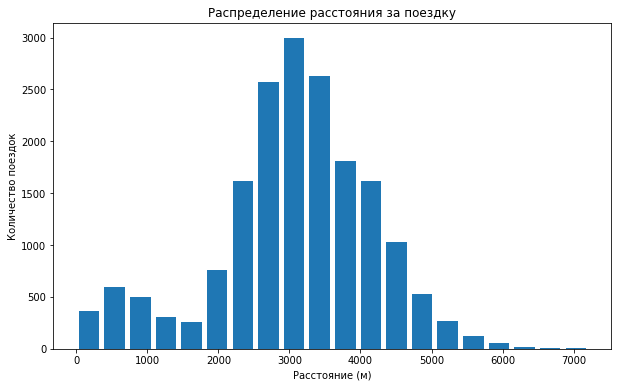

In [16]:
distance_distribution = rides_df['distance']

plt.figure(figsize=(10, 6))
distance_distribution.plot(kind='hist', bins=20, rwidth=0.8)
plt.title('Распределение расстояния за поездку')
plt.xlabel('Расстояние (м)')
plt.ylabel('Количество поездок')
plt.show()

Большинство поездок покрывает расстояние от 500-4000м, что типично для городких поездок

###  Распределение продолжительности поездок

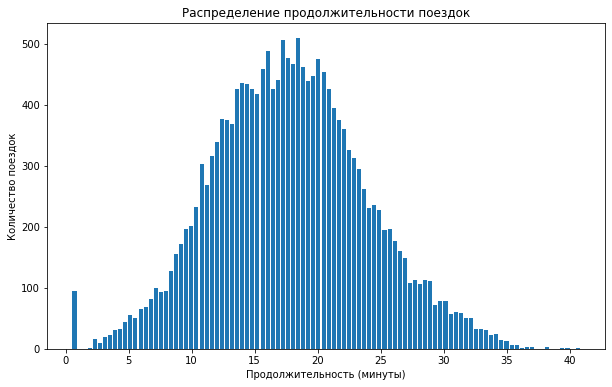

In [17]:
duration_distribution = rides_df['duration']

plt.figure(figsize=(10, 6))
duration_distribution.plot(kind='hist', bins=100, rwidth=0.8)
plt.title('Распределение продолжительности поездок')
plt.xlabel('Продолжительность (минуты)')
plt.ylabel('Количество поездок')
plt.show()

Большинство поездок длятся от 10 до 30 минут. Странный пик около 0 (1-2 минуты) может свидетельствовать о каких-нибудь акциях на бесплатные минуты, так что не стоит его удалять

## Шаг 4. Объединение данных


### Объединим таблицы в df_full

In [18]:
df_users_rides = rides_df.merge(users_df, on='user_id', how='left')
df_full = df_users_rides.merge(subs_df, on='subscription_type', how='left')


### 4.2 Создадим отдельные 2 таблицы по типу подписки

In [19]:
df_full_free = df_full.query('subscription_type == "free"')

df_full_ultra = df_full.query('subscription_type == "ultra"')

df_full_free.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6500,700,2515.690719,14.944286,2021-01-02,1,Айдар,22,Омск,free,8,50,0
6501,700,846.932642,16.234663,2021-02-01,2,Айдар,22,Омск,free,8,50,0
6502,700,4004.434142,20.016628,2021-02-04,2,Айдар,22,Омск,free,8,50,0
6503,700,1205.911290,9.782872,2021-02-10,2,Айдар,22,Омск,free,8,50,0
6504,700,3047.379435,17.427673,2021-02-14,2,Айдар,22,Омск,free,8,50,0


In [20]:
df_full_ultra.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


### Рассмотрим распределение расстояния и времени поездок для пользователей по типу подписки 

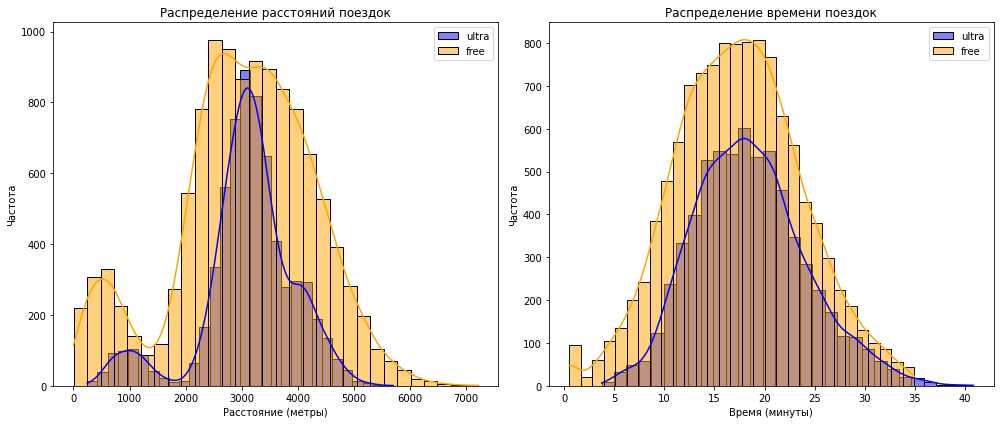

In [21]:

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_full[df_full['subscription_type'] == 'ultra']['distance'], 
             color='blue', label='ultra', kde=True, bins=30, alpha=0.5)
sns.histplot(df_full[df_full['subscription_type'] == 'free']['distance'], 
             color='orange', label='free', kde=True, bins=30, alpha=0.5)
plt.title('Распределение расстояний поездок')
plt.xlabel('Расстояние (метры)')
plt.ylabel('Частота')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(df_full[df_full['subscription_type'] == 'ultra']['duration'], 
             color='blue', label='ultra', kde=True, bins=30, alpha=0.5)
sns.histplot(df_full[df_full['subscription_type'] == 'free']['duration'], 
             color='orange', label='free', kde=True, bins=30, alpha=0.5)
plt.title('Распределение времени поездок')
plt.xlabel('Время (минуты)')
plt.ylabel('Частота')
plt.legend()

plt.tight_layout()
plt.show()


Пользователи с подпиской, в целом, проезжают более стабильные расстояния, тогда как пользователи без подписки имеют больше разнообразия в длине поездок,это указывает на то, что они совершают как короткие, так и очень длинные поездки

 Пользователи с подпиской тратят на поездки в среднем больше времени, чем пользователи без подписки. У подписчиков наблюдается меньше длинных поездок, что может свидетельствовать о более регулярном и предсказуемом использовании сервиса.

## Шаг 5. Подсчёт выручки


### Добавим столбец, который подсчитывает количество поездок и назовем его rides_count

In [22]:


df_full['duration'] = np.ceil(df_full['duration']).astype(int)
df_full['rides_count'] = 1
df_gr = df_full.pivot_table(
    index=['user_id', 'city', 'subscription_type', 'name', 'age', 'month', 'minute_price', 'start_ride_price', 'subscription_fee'],
    aggfunc={'distance': 'sum', 'duration': 'sum', 'rides_count': 'sum'}
)
df_gr = df_gr.reset_index()

df_gr

,user_id,city,subscription_type,name,age,month,minute_price,start_ride_price,subscription_fee,distance,duration,rides_count
0,1,Тюмень,ultra,Кира,22,1,6,0,199,7027.511294,42,2
1,1,Тюмень,ultra,Кира,22,4,6,0,199,754.159807,7,1
2,1,Тюмень,ultra,Кира,22,8,6,0,199,6723.470560,46,2
3,1,Тюмень,ultra,Кира,22,10,6,0,199,5809.911100,32,2
4,1,Тюмень,ultra,Кира,22,11,6,0,199,7003.499363,56,3
...,...,...,...,...,...,...,...,...,...,...,...,...
11326,1534,Краснодар,free,Альберт,25,6,8,50,0,3409.468534,26,2
11327,1534,Краснодар,free,Альберт,25,8,8,50,0,7622.453034,48,2
11328,1534,Краснодар,free,Альберт,25,9,8,50,0,4928.173852,23,1
11329,1534,Краснодар,free,Альберт,25,11,8,50,0,13350.015305,78,4


### Добавим новый столбец, который подсчитывает общую выручку и назовем его revenue

In [23]:
df_gr['revenue']=  (df_gr['duration'] * df_gr['minute_price'] 
                              + df_gr['rides_count'] *  df_gr['start_ride_price']
                              + df_gr['subscription_fee'])

df_gr.head(10)

,user_id,city,subscription_type,name,age,month,minute_price,start_ride_price,subscription_fee,distance,duration,rides_count,revenue
0,1,Тюмень,ultra,Кира,22,1,6,0,199,7027.511294,42,2,451
1,1,Тюмень,ultra,Кира,22,4,6,0,199,754.159807,7,1,241
2,1,Тюмень,ultra,Кира,22,8,6,0,199,6723.470560,46,2,475
3,1,Тюмень,ultra,Кира,22,10,6,0,199,5809.911100,32,2,391
4,1,Тюмень,ultra,Кира,22,11,6,0,199,7003.499363,56,3,535
5,1,Тюмень,ultra,Кира,22,12,6,0,199,6751.629942,28,2,367
6,2,Омск,ultra,Станислав,31,3,6,0,199,10187.723006,63,3,577
7,2,Омск,ultra,Станислав,31,4,6,0,199,6164.381824,40,2,439
8,2,Омск,ultra,Станислав,31,6,6,0,199,3255.338202,14,1,283
9,2,Омск,ultra,Станислав,31,7,6,0,199,6780.722964,48,2,487


## Шаг 6. Проверка гипотез


### Первая гипотеза

In [24]:
alpha = 0.05


 H0: Средняя продолжительность поездок пользователей с подпиской <= средней продолжительности поездок без подписки
 
 H1: Средняя продолжительность поездок пользователей с подпиской > средней продолжительности поездок без подписки


In [27]:
subscribers = df_full.query('subscription_type == "ultra"')
non_subscribers = df_full.query('subscription_type == "free"')
print('Средняя продолжительность поездок пользователей с подпиской:',np.mean(subscribers['duration']))
print('Средняя продолжительность поездок пользователей без подписки:',np.mean(non_subscribers['duration']))

Средняя продолжительность поездок пользователей с подпиской: 19.037692307692307
Средняя продолжительность поездок пользователей без подписки: 17.890992392807746


In [28]:
results = st.ttest_ind(subscribers["duration"], non_subscribers["duration"],equal_var = False,alternative='greater')
print('р-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')


print('Пользователи с подпиской тратят больше времени на поездки')

р-значение: 1.1814679253701353e-36
Отвергаем нулевую гипотезу
Пользователи с подпиской тратят больше времени на поездки


### Вторая гипотеза

H0: Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров

H1: Среднее расстояние поездки пользователей с подпиской превышает 3130 метров


In [29]:
dist = df_full.query('subscription_type == "ultra"')
print('Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку:',  np.mean(dist['distance']))

results = st.ttest_1samp(dist['distance'] , 3130 , alternative = 'greater')
print('p-value', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('He отвергаем нулевую гипотезу')
    
print('Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров')

Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку: 3115.4453880370247
p-value 0.9195368847849785
He отвергаем нулевую гипотезу
Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров


### Третья гипотеза 


H0: Помесячная выручка от пользователей с подпиской не больше, чем выручка от пользователей без подписки

H1: Помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки

In [33]:
subscribers_revenue = df_gr.query('subscription_type == "ultra"')
non_subscribers_revenue = df_gr.query('subscription_type == "free"')

print('Средняя выручка от пользователей с подпиской:',np.mean(subscribers_revenue['revenue']))
print('Средняя выручка от пользователей без подписки:',np.mean(non_subscribers_revenue['revenue']))
print()

results = st.ttest_ind(subscribers_revenue['revenue'], non_subscribers_revenue['revenue'], alternative='greater')

print('p-value:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не удалось отвергнуть нулевую гипотезу")

print('Помесячная выручка от пользователей с подпиской выше')

Средняя выручка от пользователей с подпиской: 362.7921906022502
Средняя выручка от пользователей без подписки: 328.6413651073845

p-value: 1.8850394384715216e-31
Отвергаем нулевую гипотезу
Помесячная выручка от пользователей с подпиской выше


## Вывод

## Предобработка данных

Перед началом анализа были проведены важные шаги по предобработке данных:

 - Обработка пропущенных значений
 - Создание новых столбцов
 - удаление дубликатов

## Исследовательский анализ данных

В ходе исследовательского анализа данных были описана и визуализирована общая информация о пользователях и поездках

 - Большинство поездок покрывает расстояние от 500-4000м, что типично для городких поездок
 - Основная часть пользователей находится в диапозоне от 20 до 35 лет. Это соответствует тому,что молодые люди чаще пользуются кикшерингом нежели старое поколение
 - 54.43% пользователей используют подписку free, но также стоит отметить,что подпиской ultra пользуется 45.57% пользователей
 - Большинство поездок длятся от 10 до 30 минут. Странный пик около 0 (1-2 минуты) может свидетельствовать об акциях на бесплатные минуты, так что не стоит его удалять
 - Наибольший процент пользователей приходится на Пятигорск и Екатеринбург, Москва располагается всего лишь на 8 месте


## Обьединение данных

- С помощью метода merge мы обьединили данные о пользователях, поездках и подписках в один датафрейм
- Создали два датафрейма из датафрейма, созданного на этапе 4.1: 

        c данными о пользователях без подписки
        с данными о пользователях с подпиской


- Визуализировали информацию о расстоянии и времени поездок для пользователей обеих категорий.
   
   Пользователи с подпиской, в целом, проезжают более стабильные расстояния, тогда как пользователи без подписки имеют больше разнообразия в длине поездок,это указывает на то, что они совершают как короткие, так и очень длинные поездки

    Пользователи с подпиской тратят на поездки в среднем больше времени, чем пользователи без подписки. У подписчиков наблюдается меньше длинных поездок, что может свидетельствовать о более регулярном и предсказуемом использовании сервиса.

## Подсчёт выручки
- Создали датафрейм с агрегированными данными о поездках
- Добавили столбец с помесячной выручкой, которую принёс каждый пользователь

## Проверка гипотез
- пользователи с подпиской тратят больше времени на поездки и именно они могут быть более выгодными для сервиса
- Cреднее расстояние одной поездки пользователей с подпиской не превышает 3130 метров
- Выручка от пользователей c подпиской больше, чем без подписки
## Рекомендации 

Серивису стоит ориентироваться на пользователей с подпиской и объявлять акции для привлечения внимания новых клиентов,поскольку большая часть выручки приходится на данную категорию 
